Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


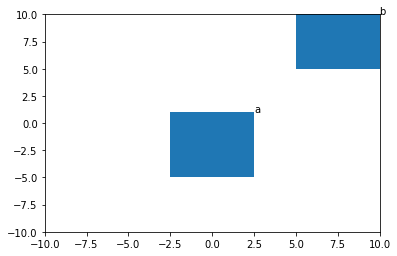

In [7]:
import polytope as pc
import numpy as np
import math

import matplotlib.patches
import matplotlib.pyplot as plt

from ApprxSimulation.LTI_simrel import tune_dratio, eps_err
from ApprxSimulation.Visualize import plot_regions, patch_ellips, ellips_cov
import ApprxSimulation.Visualize as Vis

from Models.MDP import Rpol
from Models.Linear import LTI, POMDP

from label_abstraction.mdp import *


science_regions = dict()
science_regions['a'] = pc.box2poly(np.array([[-2.5, 2.5],[-5, 1]]))
science_regions['b'] = pc.box2poly(np.array([[5, 10],[5, 10]]))
Vis.plot_regions(science_regions, [-10,10], [-10,10], tikz=True) 

In [8]:
# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2)  #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[.4,-0.2],[-0.2,0.4]])  
# noise on state transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])
# defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None

In [9]:
# Sensor noise => pomdp
H = np.eye(2) #np.ones((1,2)) # what can be measured
V = 1*np.eye(2)
    #  x^+= A x + Bu + w
    #  y = C x
    #  z = H x+v

P = np.eye(2)
mean = np.zeros((2,1))
pomdp = POMDP(sys_lti, H, V, P, mean)

L, Pst = pomdp.kalman()
print(Pst)
belief_mdp = pomdp.beliefmodel()

[[ 0.84446 -0.2862 ]
 [-0.2862   0.84446]]


In [10]:
P_init = Pst-np.eye(2)*.1
P_l =Pst-np.eye(2)*.1
P_upper =Pst #+np.eye(2)*.1

lti_belief, Error_noise,error_rank = belief_mdp.to_LTI_approx(C, P_init, P_l,P_upper, combined =False)
print Error_noise, error_rank
print(lti_belief)

P_l is a valid lower bound
P_up is a valid upper bound
(0.080108827884598055, 0.17189243466963683) (2, 2)
<Models.Linear.LTI instance at 0x7f515e6d6998>


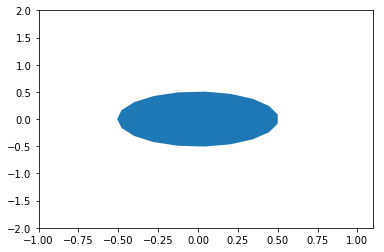

In [11]:
A = np.block([[ np.array([[math.cos(a), math.sin(a)]])] for a in np.linspace(0,2*math.pi,20)])
ball = pc.Polytope(A=A,b=np.ones((20,1)))

fig = plt.figure()
ax = fig.add_subplot(111)
 
x = pc.extreme(ball)

patch = matplotlib.patches.Polygon(.5*x)
ax.add_patch(patch)
# 

plt.xlim([-1,1.1])
plt.ylim([-2,2])

plt.show()

In [13]:
# Define spaces
lti_belief.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-3, 3]])))) # continuous set of inputs
lti_belief.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space

lti_belief_n = lti_belief.normalize()

In [22]:
d = np.array([[ 0.76481], [ 0.64426]])
eps_min = 0.935780510323
M_min = np.array([[ 1.02097, -0.01268],
                  [-0.01268,  1.00766]])
K_min = np.array([[ 0.66149, -0.67953],
                  [-0.69586, -0.7139 ]])
delta = 0.3

In [19]:
print(lti_belief_n.W)
print(lti_belief_n.T2x)
mdp_grid = lti_belief_n.abstract_io(d, un=7, Accuracy=False, verbose=False)  # do the gridding
print('--- done gridding')
mdp_grid.eps=eps_min
mdp_grid.M = M_min
mdp_grid.K = K_min
print mdp_grid

[[ 0.6  0. ]
 [ 0.   0.2]]
[[-0.70711  0.70711]
 [ 0.70711  0.70711]]
Warning no inputspace given
Warning no state space given
((1711, 49), (49, 1711, 1711))
--- done gridding
P: 
array([[ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  1.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  1.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  1.     ],
       ..., 
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.31077],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.31077],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  1.     ]])
array([[ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  1.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  1.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.99999],
       ..., 
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.66246],
       [ 0.     ,  0.     ,  0.     , ...,  0.     , 

In [20]:
#formula = '( ( ! avoid U target ) & ( F avoid ) )'
formula = '( ( F a ) & ( F b ) )'

# figure out a map dict_input2prop from numeric inputs to name based inputs
dfsa, init, final, dict_input2prop = formula_to_mdp(formula)

mdp_grid.map_dfa_inputs(dict_input2prop, science_regions)
mdp_grid.setdfa(dfsa,final)
mat=mdp_grid.act_inputs
np.sum(mdp_grid.act_inputs==0,axis=1)

('check norm of rows', array([[ 0.97015,  0.24252],
       [-0.23615,  0.97172],
       [-0.97015, -0.24252],
       [ 0.23615, -0.97172]]))
('check norm of rows', array([[ 0.97015,  0.24252],
       [-0.23615,  0.97172],
       [-0.97015, -0.24252],
       [ 0.23615, -0.97172]]))
[[ 1.  1.  1. ...,  1.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


array([  50, 1602, 1616, 1711])

In [24]:
mdp_grid.policy= None
mdp_grid.trans_qs = None
V, policy, W = mdp_grid.reach_dfa(recursions = 10,delta=delta)
print V

[[ 0.       0.       0.      ...,  0.       0.       0.     ]
 [ 0.69993  0.69998  0.7     ...,  0.69998  0.69993  0.     ]
 [ 0.       0.       0.      ...,  0.       0.       0.     ]
 [ 0.       0.       0.      ...,  0.       0.       0.     ]]


In [28]:
print mdp_grid.urep

(array([-3., -2., -1.,  0.,  1.,  2.,  3.]), array([-3., -2., -1.,  0.,  1.,  2.,  3.]))
